# Fingerprints Quality Classification
## DNN Course JCE - Final Project 
### By Kobi Amsellem & Zohar Kedem

Expirements:
* Try to classify 5 classes that represat the quality of the finger print (0 poor, 4 best)

In [54]:
# Relevenat imports
import numpy as np
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix as confusion_mtrx
from keras import layers, Sequential, models
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop


print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.7.0


**Hyperparameters**

In [3]:
# Fixed seed for split, shuffle and init
seed=9
# image height and width by avvrage dataset size
batch_size = 32
img_height = 180
img_width = 180

# splitting data ratio between train/test/val
train_split = 0.7
validation_split = 0.15
test_split = 0.15

# model hyperparameters
learning_rate = 0.001
epochs_find_best = 10
epochs_best = 100


**Loading data to train and validation tensors**

Total:  976  examples
Found 976 files belonging to 5 classes.
Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-02-03 20:41:09.055399: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 20:41:09.056149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-03 20:41:09.056536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


train 21
val 5
test 5


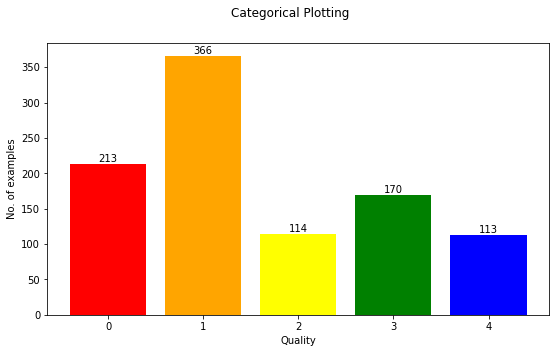

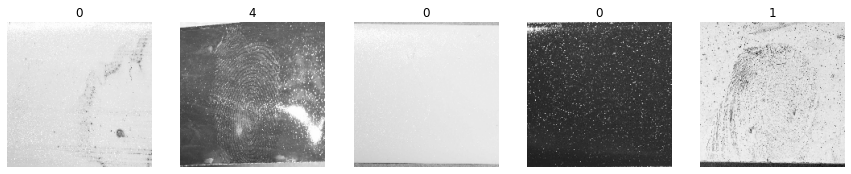

In [4]:
dirs = !ls Dataset

data_dir = pathlib.Path('./Dataset')
DATASET_SIZE = len(list(data_dir.glob('*/*.jpg')))
print('Total: ', DATASET_SIZE, ' examples')


counts = []
for dir in dirs:
  ddir = pathlib.Path('./Dataset/'+dir+'/')
  counts.append(len(list(ddir.glob('*.jpg'))))

fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
c = ['red', 'orange', 'yellow', 'green', 'blue']
axs.bar(dirs, counts, color=c)
axs.set_ylabel('No. of examples')
axs.set_xlabel('Quality')
axs.bar_label(axs.containers[0])
fig.suptitle('Categorical Plotting')

full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='categorical',
  )

train_size = int(train_split * (DATASET_SIZE/batch_size))
val_size = int(validation_split * (DATASET_SIZE/batch_size))
test_size = int(test_split * (DATASET_SIZE/batch_size))

full_dataset = full_dataset.shuffle(seed)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size+1)
test_dataset = test_dataset.take(test_size+1)

print("train", len(train_dataset))
print("val", len(val_dataset))
print("test", len(test_dataset))

train_dataset = train_dataset
val_dataset = val_dataset
test_dataset = test_dataset


plt.figure(figsize=(15, 5))
for images, labels in train_dataset.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i].numpy()))
    plt.axis("off")

**Data Augmentation**
Set sequential data augmentation pipeline:

* Random Rotation
* Random Flip
* Random Contrast

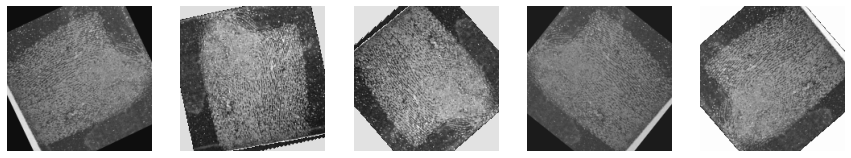

In [5]:
data_augmentation = Sequential()
data_augmentation.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=seed))
data_augmentation.add(layers.RandomRotation((0,1),fill_mode="constant",interpolation="bilinear",seed=seed,fill_value=0.0))
data_augmentation.add(layers.RandomContrast(0.4, seed=None))

plt.figure(figsize=(15, 5))
with tf.device('/cpu:0'):
    for images, _ in train_dataset.take(1):
        for i in range(5):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

### Classification Layers ###



In [6]:
fc_classifier = Sequential()
fc_classifier.add(layers.Flatten())
fc_classifier.add(layers.Dense(512, activation='relu'))
fc_classifier.add(layers.Dropout(0.4))
fc_classifier.add(layers.Dense(128, activation='relu'))
fc_classifier.add(layers.Dropout(0.3))
fc_classifier.add(layers.Dense(32, activation='relu'))
fc_classifier.add(layers.Dropout(0.2))
fc_classifier.add(layers.Dense(5, activation='softmax'))



### Comparing Models: ###

* MobileNetV2 - Full Training
* MobileNetV2 - Pretrained
* ResNet50 - Pretrained
* EfficientNetB2 - Pretrained
* Inception_V3 - Pretrained
* Xception  - Pretrained

#### Optimizers: ####
 Adam, Nadam



#### MobileNet Full Training - Adam ####

In [29]:
MobileNetV2_FullTraining = Sequential(
    tf.keras.applications.MobileNetV2(include_top=False, input_shape=(180,180,3), pooling='max')
)

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
MobileNetV2_FullTraining.add(classifier)
MobileNetV2_FullTraining.build((None, 180, 180, 3))
MobileNetV2_FullTraining.summary()
MobileNetV2_FullTraining.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

MobileNetV2_FullTraining_history = MobileNetV2_FullTraining.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 sequential_1 (Sequential)   (None, 5)                 725829    
                                                                 
Total params: 2,983,813
Trainable params: 2,949,701
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10


2022-02-03 21:21:47.937621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 2.6041 - accuracy: 0.3690

2022-02-03 21:21:58.717541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 18s 414ms/step - loss: 2.6041 - accuracy: 0.3690 - val_loss: 3.4535 - val_accuracy: 0.2569
Epoch 2/10
21/21 [==============================] - 7s 288ms/step - loss: 1.0937 - accuracy: 0.6012 - val_loss: 2.3338 - val_accuracy: 0.2500
Epoch 3/10
21/21 [==============================] - 6s 273ms/step - loss: 0.9358 - accuracy: 0.6429 - val_loss: 3.5523 - val_accuracy: 0.2431
Epoch 4/10
21/21 [==============================] - 7s 283ms/step - loss: 0.8424 - accuracy: 0.6905 - val_loss: 4.6873 - val_accuracy: 0.2062
Epoch 5/10
21/21 [==============================] - 6s 269ms/step - loss: 0.8506 - accuracy: 0.6905 - val_loss: 4.5461 - val_accuracy: 0.2014
Epoch 6/10
21/21 [==============================] - 6s 271ms/step - loss: 0.7090 - accuracy: 0.7366 - val_loss: 7.6245 - val_accuracy: 0.2313
Epoch 7/10
21/21 [==============================] - 6s 275ms/step - loss: 0.7018 - accuracy: 0.7560 - val_loss: 4.4050 - val_accuracy: 0.2222
Epoch 8/10
21/21

#### MobileNet Pretrained - Adam ####

In [24]:
MobileNetV2 = Sequential(
    tf.keras.applications.MobileNetV2(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
)
for layer in MobileNetV2.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
MobileNetV2.add(classifier)
MobileNetV2.build((None, 180, 180, 3))
MobileNetV2.summary()
MobileNetV2.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

MobileNetV2_history = MobileNetV2.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 sequential_1 (Sequential)   (None, 5)                 725829    
                                                                 
Total params: 2,983,813
Trainable params: 725,829
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


2022-02-03 21:12:57.822508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.6349 - accuracy: 0.3720

2022-02-03 21:13:02.750969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 10s 271ms/step - loss: 1.6349 - accuracy: 0.3720 - val_loss: 1.4666 - val_accuracy: 0.3819
Epoch 2/10
21/21 [==============================] - 4s 177ms/step - loss: 1.4163 - accuracy: 0.4211 - val_loss: 1.3144 - val_accuracy: 0.5694
Epoch 3/10
21/21 [==============================] - 4s 170ms/step - loss: 1.3541 - accuracy: 0.4628 - val_loss: 1.2809 - val_accuracy: 0.5278
Epoch 4/10
21/21 [==============================] - 5s 192ms/step - loss: 1.2626 - accuracy: 0.5134 - val_loss: 1.1521 - val_accuracy: 0.5972
Epoch 5/10
21/21 [==============================] - 4s 168ms/step - loss: 1.2665 - accuracy: 0.4940 - val_loss: 1.1653 - val_accuracy: 0.5903
Epoch 6/10
21/21 [==============================] - 4s 165ms/step - loss: 1.2332 - accuracy: 0.5387 - val_loss: 1.1283 - val_accuracy: 0.6181
Epoch 7/10
21/21 [==============================] - 4s 169ms/step - loss: 1.1673 - accuracy: 0.5283 - val_loss: 1.1589 - val_accuracy: 0.5437
Epoch 8/10
21/21

#### ResNet50 - Adam ####

In [7]:
ResNet50 = Sequential(
    tf.keras.applications.ResNet50(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
)
for layer in ResNet50.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
ResNet50.add(classifier)
ResNet50.build((None, 180, 180, 3))
ResNet50.summary()
ResNet50.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

ResNet50_history = ResNet50.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential_1 (Sequential)   (None, 5)                 1119045   
                                                                 
Total params: 24,706,757
Trainable params: 1,119,045
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10


2022-02-03 20:41:20.527520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.4873 - accuracy: 0.4598

2022-02-03 20:41:26.132196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 10s 272ms/step - loss: 1.4873 - accuracy: 0.4598 - val_loss: 1.1591 - val_accuracy: 0.5188
Epoch 2/10
21/21 [==============================] - 5s 218ms/step - loss: 1.2038 - accuracy: 0.5268 - val_loss: 1.0646 - val_accuracy: 0.5938
Epoch 3/10
21/21 [==============================] - 5s 218ms/step - loss: 1.0299 - accuracy: 0.5893 - val_loss: 0.9097 - val_accuracy: 0.6687
Epoch 4/10
21/21 [==============================] - 5s 219ms/step - loss: 0.9491 - accuracy: 0.6265 - val_loss: 0.8589 - val_accuracy: 0.6875
Epoch 5/10
21/21 [==============================] - 6s 245ms/step - loss: 0.8910 - accuracy: 0.6592 - val_loss: 0.7692 - val_accuracy: 0.6736
Epoch 6/10
21/21 [==============================] - 5s 225ms/step - loss: 0.9065 - accuracy: 0.6384 - val_loss: 0.8352 - val_accuracy: 0.6813
Epoch 7/10
21/21 [==============================] - 5s 229ms/step - loss: 0.8170 - accuracy: 0.6741 - val_loss: 0.6870 - val_accuracy: 0.7188
Epoch 8/10
21/21

#### EfficientNetB2 - Adam ####

In [8]:
EfficientNetB2 = Sequential(
    tf.keras.applications.EfficientNetB2(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
)
for layer in EfficientNetB2.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
EfficientNetB2.add(classifier)
EfficientNetB2.build((None, 180, 180, 3))
EfficientNetB2.summary()
EfficientNetB2.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

EfficientNetB2_history = EfficientNetB2.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 sequential_1 (Sequential)   (None, 5)                 791365    
                                                                 
Total params: 8,559,934
Trainable params: 791,365
Non-trainable params: 7,768,569
_________________________________________________________________
Epoch 1/10


2022-02-03 20:51:07.621067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.4970

2022-02-03 20:51:14.186779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 15s 332ms/step - loss: 1.2730 - accuracy: 0.4970 - val_loss: 1.0223 - val_accuracy: 0.5875
Epoch 2/10
21/21 [==============================] - 5s 214ms/step - loss: 0.9329 - accuracy: 0.6473 - val_loss: 0.8116 - val_accuracy: 0.6625
Epoch 3/10
21/21 [==============================] - 5s 209ms/step - loss: 0.8433 - accuracy: 0.6726 - val_loss: 0.6480 - val_accuracy: 0.7250
Epoch 4/10
21/21 [==============================] - 6s 253ms/step - loss: 0.7627 - accuracy: 0.6905 - val_loss: 0.6592 - val_accuracy: 0.7708
Epoch 5/10
21/21 [==============================] - 5s 214ms/step - loss: 0.7144 - accuracy: 0.7277 - val_loss: 0.6383 - val_accuracy: 0.7438
Epoch 6/10
21/21 [==============================] - 5s 211ms/step - loss: 0.6508 - accuracy: 0.7440 - val_loss: 0.5222 - val_accuracy: 0.7986
Epoch 7/10
21/21 [==============================] - 5s 234ms/step - loss: 0.6414 - accuracy: 0.7426 - val_loss: 0.5484 - val_accuracy: 0.8188
Epoch 8/10
21/21

### Inception_V3 - Adam

In [17]:
InceptionV3 = Sequential(
    tf.keras.applications.InceptionV3(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
)
for layer in InceptionV3.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
InceptionV3.add(classifier)
InceptionV3.build((None, 180, 180, 3))
InceptionV3.summary()
InceptionV3.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

InceptionV3_history = InceptionV3.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 sequential_1 (Sequential)   (None, 5)                 1119045   
                                                                 
Total params: 22,921,829
Trainable params: 1,119,045
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10


2022-02-03 20:57:59.193043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 21.4038 - accuracy: 0.2887

2022-02-03 20:58:03.773247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 11s 297ms/step - loss: 21.4038 - accuracy: 0.2887 - val_loss: 4.0419 - val_accuracy: 0.3681
Epoch 2/10
21/21 [==============================] - 4s 167ms/step - loss: 7.2695 - accuracy: 0.3423 - val_loss: 1.8255 - val_accuracy: 0.3250
Epoch 3/10
21/21 [==============================] - 4s 173ms/step - loss: 3.5979 - accuracy: 0.2619 - val_loss: 1.5955 - val_accuracy: 0.1250
Epoch 4/10
21/21 [==============================] - 4s 172ms/step - loss: 2.0883 - accuracy: 0.2976 - val_loss: 1.6043 - val_accuracy: 0.3563
Epoch 5/10
21/21 [==============================] - 4s 172ms/step - loss: 1.9238 - accuracy: 0.3214 - val_loss: 1.6003 - val_accuracy: 0.3563
Epoch 6/10
21/21 [==============================] - 4s 175ms/step - loss: 1.7580 - accuracy: 0.3765 - val_loss: 1.5920 - val_accuracy: 0.4236
Epoch 7/10
21/21 [==============================] - 4s 173ms/step - loss: 1.6367 - accuracy: 0.3527 - val_loss: 1.5839 - val_accuracy: 0.4167
Epoch 8/10
21/2

In [18]:
Xception = Sequential(
    tf.keras.applications.Xception(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
)
for layer in Xception.layers:
        layer.trainable=False

classifier = models.clone_model(fc_classifier)
classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
Xception.add(classifier)
Xception.build((None, 180, 180, 3))
Xception.summary()
Xception.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

Xception_history = Xception.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 sequential_1 (Sequential)   (None, 5)                 1119045   
                                                                 
Total params: 21,980,525
Trainable params: 1,119,045
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/10


2022-02-03 21:05:16.593906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 14.6067 - accuracy: 0.3036

2022-02-03 21:05:22.853582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 11s 356ms/step - loss: 14.6067 - accuracy: 0.3036 - val_loss: 2.9460 - val_accuracy: 0.3958
Epoch 2/10
21/21 [==============================] - 6s 259ms/step - loss: 5.2527 - accuracy: 0.3244 - val_loss: 1.6160 - val_accuracy: 0.2708
Epoch 3/10
21/21 [==============================] - 6s 262ms/step - loss: 2.7632 - accuracy: 0.3363 - val_loss: 1.5894 - val_accuracy: 0.3875
Epoch 4/10
21/21 [==============================] - 6s 278ms/step - loss: 1.9914 - accuracy: 0.3780 - val_loss: 1.6680 - val_accuracy: 0.3938
Epoch 5/10
21/21 [==============================] - 6s 274ms/step - loss: 1.6548 - accuracy: 0.4107 - val_loss: 1.5943 - val_accuracy: 0.3875
Epoch 6/10
21/21 [==============================] - 6s 267ms/step - loss: 1.7008 - accuracy: 0.3705 - val_loss: 1.5790 - val_accuracy: 0.3889
Epoch 7/10
21/21 [==============================] - 6s 269ms/step - loss: 1.5536 - accuracy: 0.3601 - val_loss: 1.5561 - val_accuracy: 0.3889
Epoch 8/10
21/2

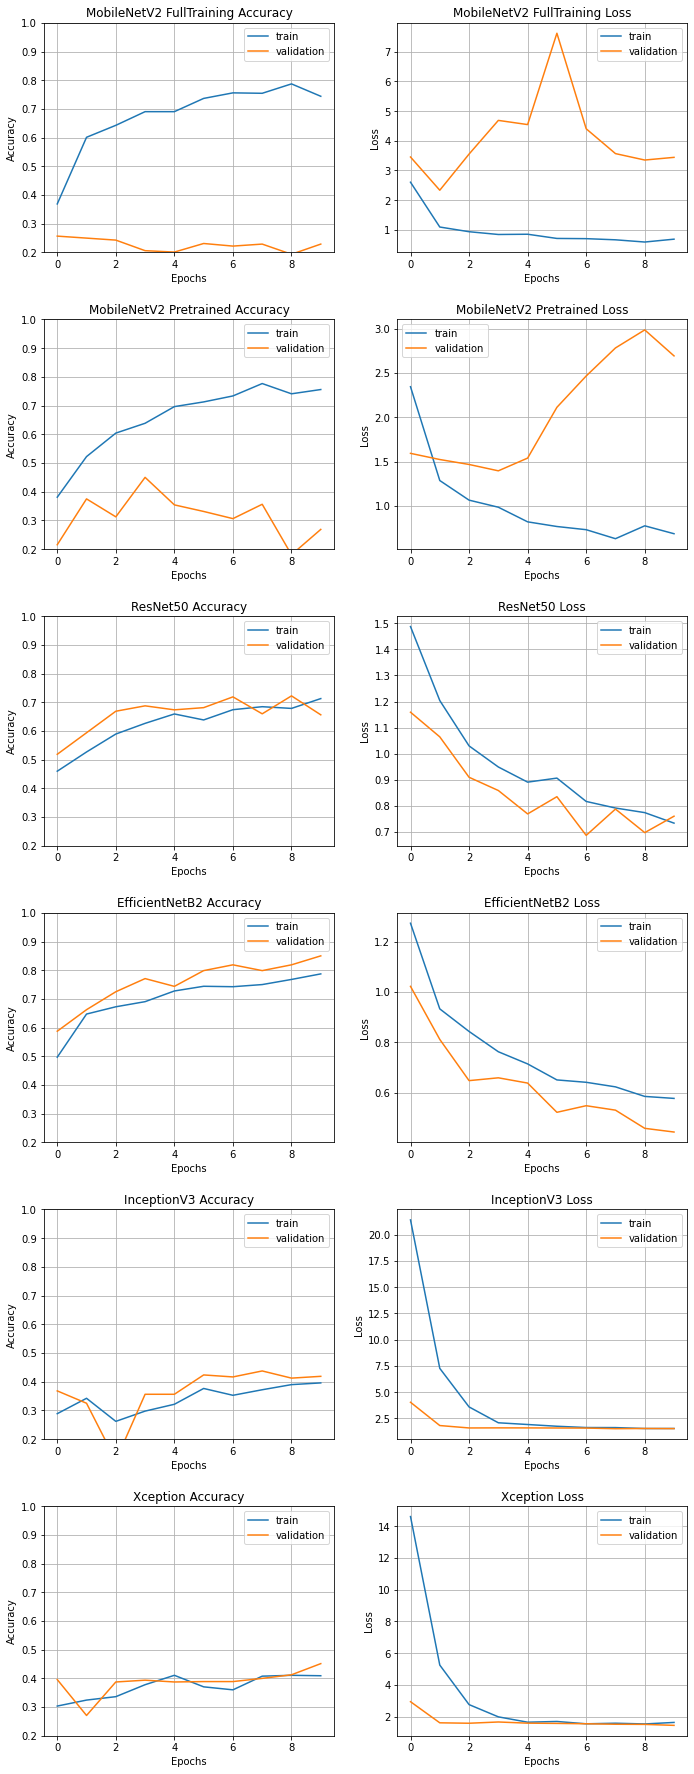

Best Model by Validation set:  EfficientNetB2  With Accuracy of:  0.8500000238418579


In [47]:
models_history = [MobileNetV2_FullTraining_history, MobileNetV2_history, ResNet50_history, EfficientNetB2_history, InceptionV3_history, Xception_history]
models_names = ['MobileNetV2 FullTraining', 'MobileNetV2 Pretrained', 'ResNet50', 'EfficientNetB2', 'InceptionV3', 'Xception']

best_model_acc = 0
best_model = ""
plt.figure(figsize=(10, 25))
for history, name, i in zip(models_history, models_names, range(1, 7)):

    if best_model_acc < history.history['val_accuracy'][-1]:
        best_model_acc = history.history['val_accuracy'][-1]
        best_model = name

    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    plt.subplot(6, 2, 2*i-1)
    fig1 = plt.gcf()
    plt.plot(acc_history)
    plt.plot(val_acc_history)
    plt.axis(ymin=0.2,ymax=1)
    plt.grid()
    plt.title(name + ' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

    plt.subplot(6, 2, 2*i)
    fig2 = plt.gcf()
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.grid()
    plt.title(name+' Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

    

plt.tight_layout(pad=2.0)
plt.show()


print("Best Model by Validation set: ", best_model, " With Accuracy of: ", best_model_acc)
    

#### Search Best Optimizer ####

* ##### Adam, Nadam, RMSprop #####

In [72]:
optimizers = [Adam, Nadam, RMSprop]
optimizers_name = ['Adam', 'Nadam', 'RMSprop']
opts_history = []
for opt, name in zip(optimizers, optimizers_name):
    model = Sequential(
        tf.keras.applications.EfficientNetB2(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
    )
    for layer in model.layers:
            layer.trainable=False

    classifier = models.clone_model(fc_classifier)
    classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
    model.add(classifier)
    model.build((None, 180, 180, 3))
    model.compile(optimizer=opt(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

    model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best, verbose=0)
    opts_history.append(model_history)


2022-02-03 22:55:02.186663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 22:55:24.139096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 22:56:43.173420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 22:57:09.621427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 22:58:34.376735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 22:58:55.777405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


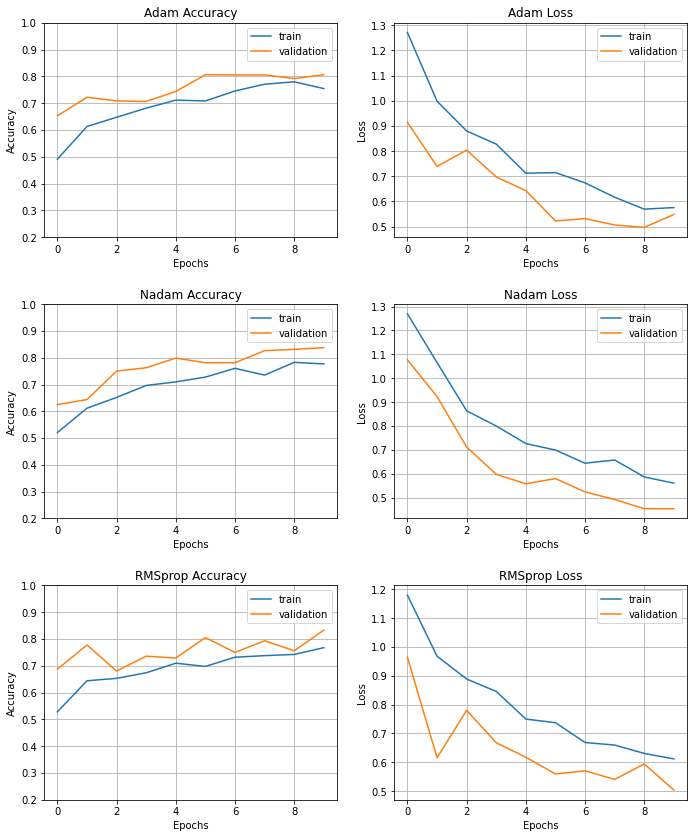

Best Optimizer for EfficientNetB2 by Validation set:  Nadam  With Accuracy of:  0.875


In [73]:
best_opt_acc = 0
best_opt = ""
plt.figure(figsize=(10, 12))
for history, name, i in zip(opts_history, optimizers_name, range(1, 4)):

    if best_model_acc < history.history['val_accuracy'][-1]:
        best_model_acc = history.history['val_accuracy'][-1]
        best_model = name

    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    plt.subplot(3, 2, 2*i-1)
    fig1 = plt.gcf()
    plt.plot(acc_history)
    plt.plot(val_acc_history)
    plt.axis(ymin=0.2,ymax=1)
    plt.grid()
    plt.title(name + ' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

    plt.subplot(3, 2, 2*i)
    fig2 = plt.gcf()
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.grid()
    plt.title(name+' Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()


print("Best Optimizer for EfficientNetB2 by Validation set: ", best_model, " With Accuracy of: ", best_model_acc)


#### Search Best Learning Rate ####

* ##### [0.1, 0.01, 0.001, 0.0001, 0.00001] #####

In [74]:
learning_rates = [0.1, 0.1e-1, 0.1e-2, 0.1e-3, 0.1e-4]
lrs_history = []
for lr in learning_rates:
    model = Sequential(
        tf.keras.applications.EfficientNetB2(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
    )
    for layer in model.layers:
            layer.trainable=False

    classifier = models.clone_model(fc_classifier)
    classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
    model.add(classifier)
    model.build((None, 180, 180, 3))
    model.compile(optimizer=Nadam(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])

    model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best, verbose=0)
    lrs_history.append(model_history)

2022-02-03 23:06:01.917085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:06:29.847895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:08:04.108489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:08:36.249004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:10:07.869809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:10:45.889990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:12:27.947414: I tensorflow/core/grappler/optimizers/cust

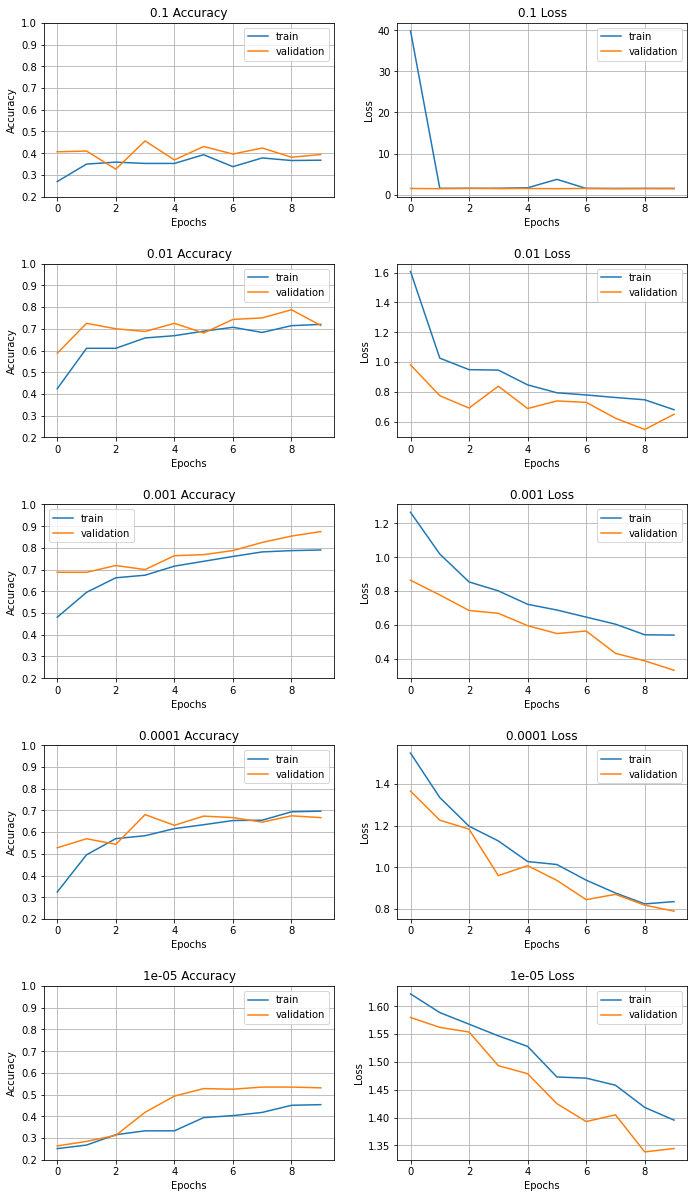

Best Learning Rate for EfficientNetB2 with Nadam by Validation set:  0.001  With Accuracy of:  0.875


In [82]:
best_lr_acc = 0
best_lr = ""
plt.figure(figsize=(10, 17))
for history, lr, i in zip(lrs_history, learning_rates, range(1, 7)):

    if best_lr_acc < history.history['val_accuracy'][-1]:
        best_lr_acc = history.history['val_accuracy'][-1]
        best_lr = lr

    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    plt.subplot(5, 2, 2*i-1)
    fig1 = plt.gcf()
    plt.plot(acc_history)
    plt.plot(val_acc_history)
    plt.axis(ymin=0.2,ymax=1)
    plt.grid()
    plt.title(str(lr) + ' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

    plt.subplot(5, 2, 2*i)
    fig2 = plt.gcf()
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.grid()
    plt.title(str(lr)+' Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()


print("Best Learning Rate for EfficientNetB2 with Nadam by Validation set: ", str(best_lr), " With Accuracy of: ", best_lr_acc)

#### Search Best Loss ####

* ##### Categorical Crossentropy, Cosine Similarity, Categorical Hinge #####

In [83]:
losses = ['categorical_crossentropy', 'cosine_similarity', 'categorical_hinge']

losses_history = []
for loss in losses:
    model = Sequential(
        tf.keras.applications.EfficientNetB2(include_top=False, input_shape=(180,180,3), pooling='avg',classes=5, weights='imagenet')
    )
    for layer in model.layers:
            layer.trainable=False

    classifier = models.clone_model(fc_classifier)
    classifier = fc_classifier.__class__.from_config(fc_classifier.get_config())
    model.add(classifier)
    model.build((None, 180, 180, 3))
    model.compile(optimizer=Nadam(learning_rate=best_lr),loss=loss, metrics=['accuracy'])

    model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_best, verbose=0)
    losses_history.append(model_history)

2022-02-03 23:21:25.579824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:22:01.192936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:23:24.427358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:24:00.935247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:25:23.287672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 23:26:03.664803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


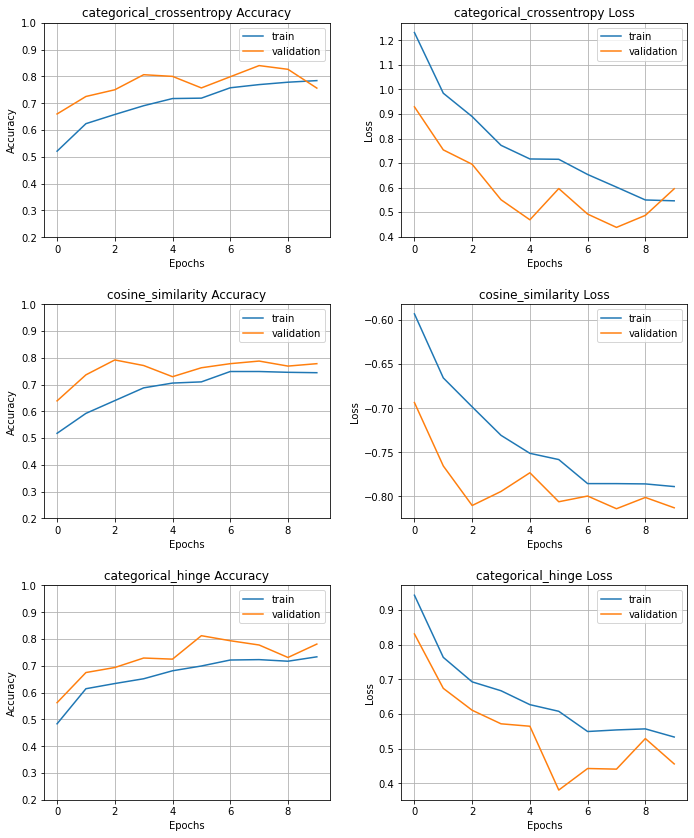

Best Loss for EfficientNetB2 with Nadam by Validation set:  categorical_hinge  With Accuracy of:  0.78125


In [86]:
best_loss_acc = 0
best_loss = ""
plt.figure(figsize=(10, 12))
for history, loss, i in zip(losses_history, losses, range(1, 4)):

    if best_loss_acc < history.history['val_accuracy'][-1]:
        best_loss_acc = history.history['val_accuracy'][-1]
        best_loss = loss

    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    plt.subplot(3, 2, 2*i-1)
    fig1 = plt.gcf()
    plt.plot(acc_history)
    plt.plot(val_acc_history)
    plt.axis(ymin=0.2,ymax=1)
    plt.grid()
    plt.title(loss + ' Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

    plt.subplot(3, 2, 2*i)
    fig2 = plt.gcf()
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.grid()
    plt.title(loss+' Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

plt.tight_layout(pad=2.0)
plt.show()


print("Best Loss for EfficientNetB2 with Nadam by Validation set: ", best_loss, " With Accuracy of: ", best_loss_acc)

### Confusion Metrix ###

2022-02-03 21:46:27.336683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 21:46:32.264706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


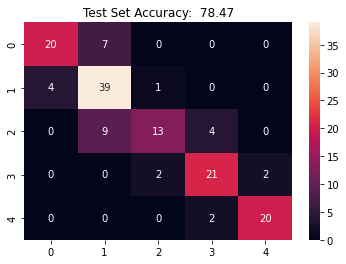

In [48]:

y_test = []
y_predict = []

for images, labels in test_dataset:
    tmp_predict = EfficientNetB2.predict(images)
    tmp_true_max = np.argmax(labels.numpy(), axis=1).astype(np.uint8)
    tmp_pred_max = np.argmax(tmp_predict, axis=1).astype(np.uint8)
    y_test = [*y_test, *tmp_true_max]
    y_predict = [*y_predict, *tmp_pred_max]


cm = confusion_mtrx(y_test, y_predict)
sn.heatmap(cm ,annot = True)
acc = (np.array(y_test) == np.array(y_predict)).sum()/len(y_test)
plt.title("Test Set Accuracy:  "+str(round(acc*100, 2)))
plt.show()